In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import scipy.stats as stats

palette = sns.color_palette("GnBu_r", 9)
plt.rcParams['figure.figsize'] = [6, 4]
plt.rcParams['figure.dpi'] = 100

# Testing Benford's Law

I first heard about Benford's Law on a Netflix documentary Connected. Finding this very hard to grok I decided to write some code to test this out for a few cases. First, we need to check the hypothesis and generate the ideal data.

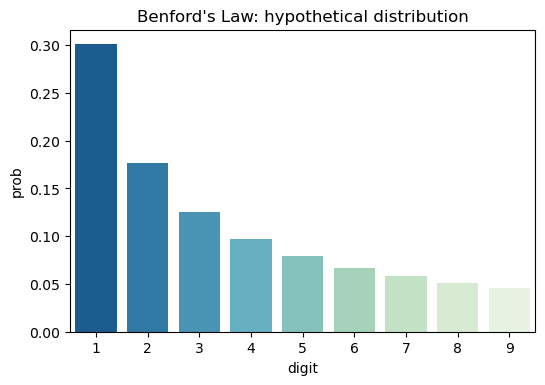

In [2]:
#P(n)=log10(1+1/n)

benford_proba = ({'digit': i, 'prob': np.log10(1+1/i)} for i in range(1,10,1))
ideal_df = pd.DataFrame(benford_proba)
sns.barplot(x='digit', y='prob', data=ideal_df, palette=palette).set_title('Benford\'s Law: hypothetical distribution')
plt.show()

In [3]:
def plot_benford(x, y, data, title, ax=None):
    data = data.sort_values(x)
    benford_proba = (np.log10(1+1/i) for i in range(1,10,1))
    
    observed = list(data[y])
    expected = [round(prob*np.sum(data[y])) for prob in benford_proba]
    stat, p_value = stats.chisquare(f_obs=observed, f_exp=expected)
    
    if p_value > 0.05:
        palette = sns.color_palette("GnBu_r", 9)
    else:
        palette = sns.color_palette("OrRd_r", 9)
    
    frequencies = data[y]/np.sum(data[y])

    if ax is None:
        fig, ax = plt.subplots()
    
    sns.barplot(x=data[x], y=frequencies, palette=palette, ax=ax, zorder=0).set_title(title)
    sns.pointplot(x='digit', y='prob', data=ideal_df, ax=ax, zorder=1, join=False, color='gray')
    ax.set(xlabel='First Digit', ylabel='Frequency')

# Belgian City Populations

The first thing we'll check is the poputation of cities, as this was an example in the show (without the actual numbers to back it up). Here we'll check if this is true for Belgian Cities. As only the top 400 is listed we'll scale the data down so the smallest city has one inhabitant (otherwise the requirements are violated).

In [4]:
df = pd.read_table('./data/belgian_cities_population.csv', sep=',')
df['scaled_pop'] = df['pop'] - np.min(df['pop']) + 1 # scale data so smallest value is 1
df['first_digit'] = [str(n)[0] for n in df['scaled_pop']]
counts_cities_df = df.groupby('first_digit').agg(
    count = pd.NamedAgg('name', 'count')
).reset_index()

counts_cities_df

,first_digit,count
0,1,131
1,2,75
2,3,38
3,4,35
4,5,26
5,6,34
6,7,27
7,8,17
8,9,17


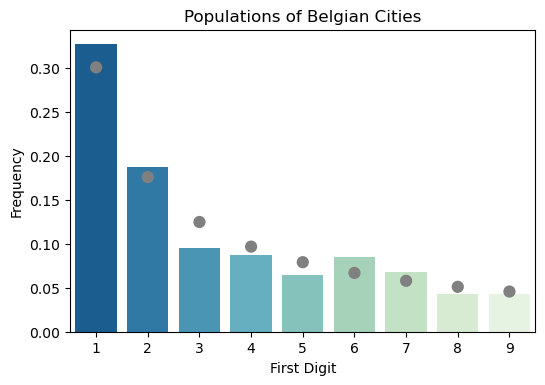

In [5]:
plot_benford('first_digit', 'count', counts_cities_df, "Populations of Belgian Cities")

# Gwent Pro-Rank MMR scores

Let's check if Benford's law applies to Gwent MMR scores from last season. As the scores start at 9600 for players that completed their placements (25 games with four factions, other players are ignored) and only the top 2860 players are included we'll scale the scores so the lowest score is 1.

In [6]:
df = pd.read_excel('./data/player_stats.xlsx').drop(columns='Unnamed: 0')
df = df[df['mmr'] >= 9600]
df['scaled_mmr'] = df['mmr']-9600+1
df['first_digit'] = [str(n)[0] for n in df['scaled_mmr']]
counts_gwent_df = df.groupby('first_digit').agg(
    count = pd.NamedAgg('name', 'count')
).reset_index()

counts_gwent_df


,first_digit,count
0,1,7387
1,2,3565
2,3,2600
3,4,1664
4,5,1057
5,6,1096
6,7,1173
7,8,1089
8,9,982


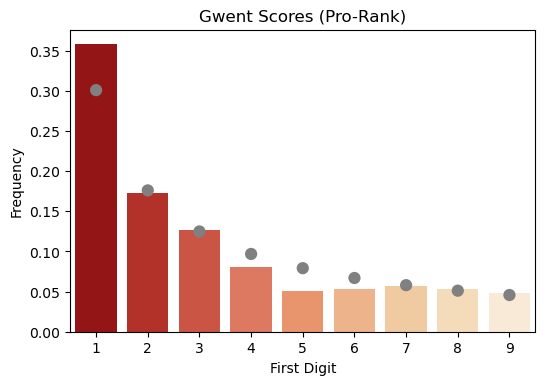

In [7]:
plot_benford('first_digit', 'count',counts_gwent_df, "Gwent Scores (Pro-Rank)")

# Altitude of the World's Capitals

We can check if the law holds true for the altitude of different capitals in the world. Data from Wikipedia, we'll filter all captials which are at sea level as 0 is not a number we can consider for this.

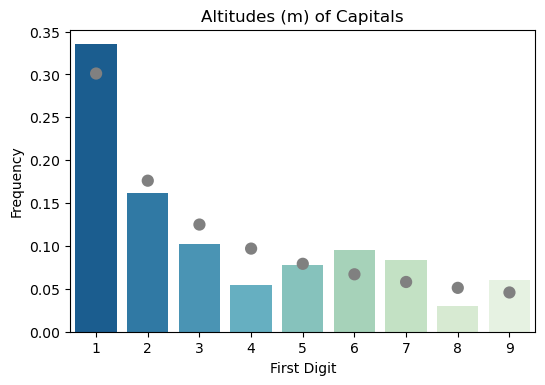

In [8]:
df = pd.read_excel('./data/capitals_altitude.xlsx')
df = df[df['Elevation (m)'] > 0]

df['first_digit_m'] = [str(n)[0] for n in df['Elevation (m)']]
df['first_digit_ft'] = [str(n)[0] for n in df['Elevation (ft)']]
                        
counts_altitude_df = df.groupby('first_digit_m').agg(
    count = pd.NamedAgg('Country', 'count'),
).reset_index()


plot_benford('first_digit_m', 'count', counts_altitude_df, "Altitudes (m) of Capitals")

In [9]:
counts_altitude_df

,first_digit_m,count
0,1,56
1,2,27
2,3,17
3,4,9
4,5,13
5,6,16
6,7,14
7,8,5
8,9,10


# Bacteria in the Human Gut


In [10]:
# Original file: http://downloads.hmpdacc.org/data/HMQCP/otu_table_psn_v35.txt.gz
# Header was removed and recompressed
df = pd.read_table('./data/v35_psn_otu.genus.fixed.txt.gz', compression='gzip')

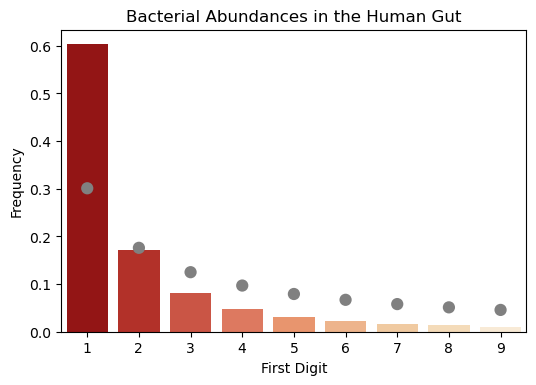

In [11]:
first_digits = (str(x)[0] for x in df.drop(columns=["#OTU ID", "Consensus Lineage"]).values.flatten() if float(x) > 0)
c = Counter(first_digits)
counts_microbiome_df = pd.DataFrame([(k,v) for k,v in c.items()])
counts_microbiome_df.columns = ['first_digit', 'count']

plot_benford('first_digit', 'count',counts_microbiome_df, "Bacterial Abundances in the Human Gut")

# COVID-19 Infections in Belgium

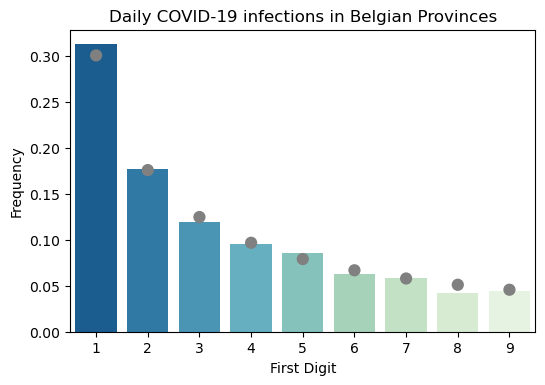

In [12]:
df = pd.read_csv('./data/COVID19BE_CASES_AGESEX.csv').dropna()

grouped_df = df.groupby(['DATE', 'PROVINCE']).agg(
    count = pd.NamedAgg('CASES', 'sum')
).reset_index()

grouped_df['first_digit'] = [str(n)[0] for n in grouped_df['count']]

counts_covid_df = grouped_df.groupby('first_digit').agg(
    count = pd.NamedAgg('first_digit', 'count')
).reset_index()

plot_benford('first_digit', 'count', counts_covid_df, "Daily COVID-19 infections in Belgian Provinces")

# Final Summary

Let's group our plots together in one graph that can be used for the blog.

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]


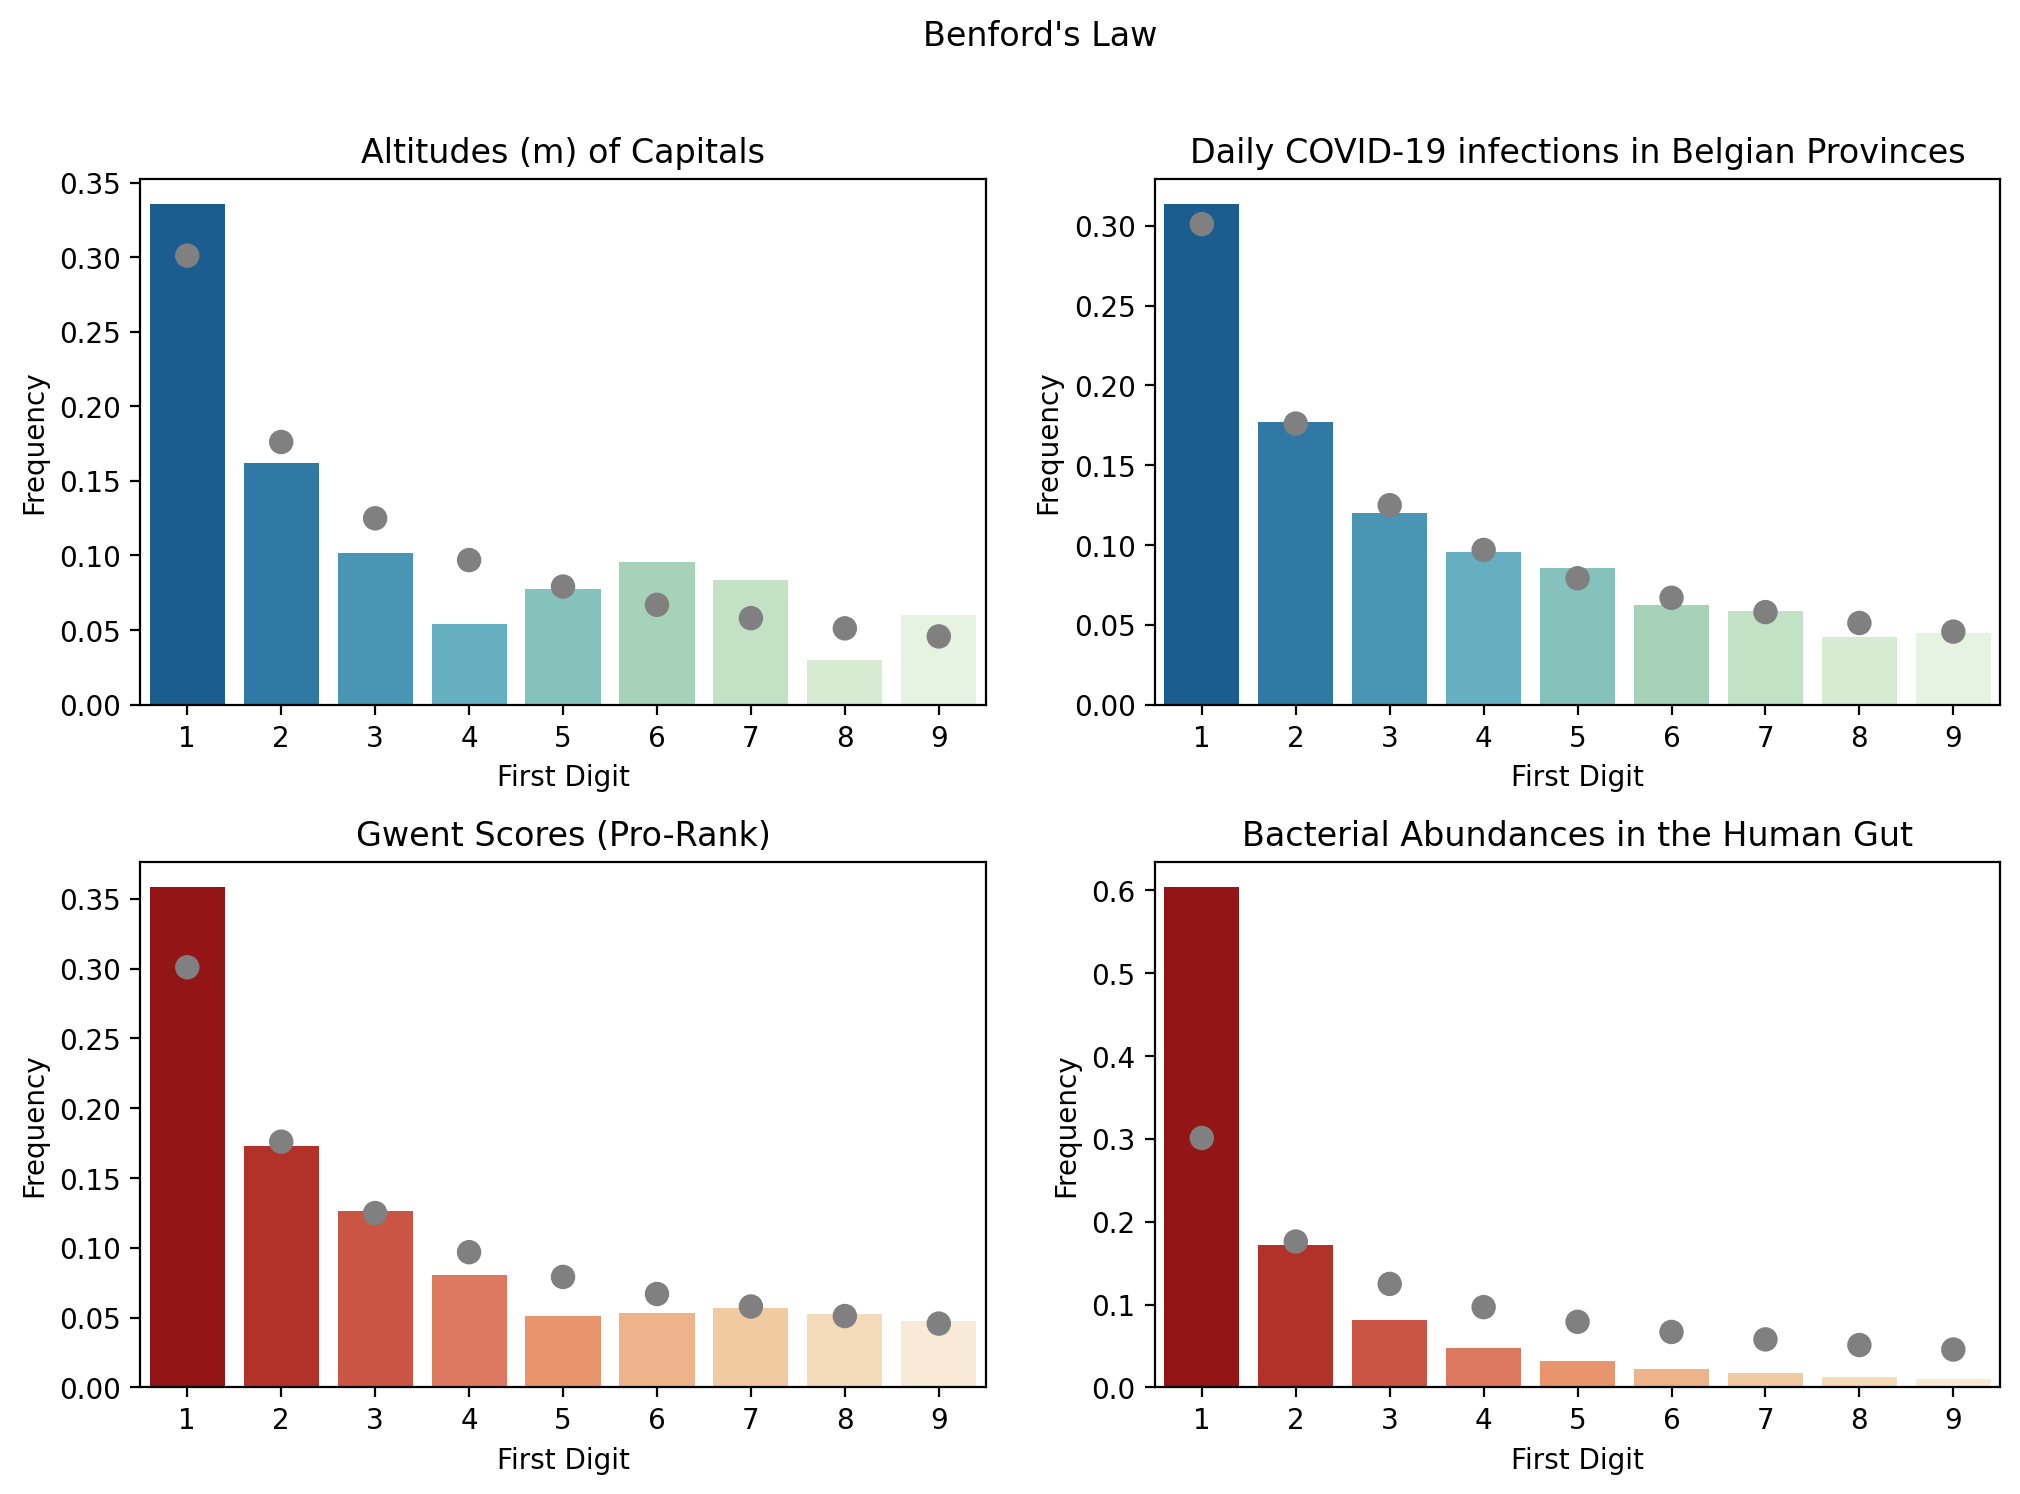

In [13]:
# Summary picture
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 200

fig, axs = plt.subplots(2,2)
fig.suptitle('Benford\'s Law')
plot_benford('first_digit', 'count', counts_covid_df, "Daily COVID-19 infections in Belgian Provinces", ax=axs[0, 1])
plot_benford('first_digit', 'count', counts_microbiome_df, "Bacterial Abundances in the Human Gut", ax=axs[1, 1])
plot_benford('first_digit_m', 'count', counts_altitude_df, "Altitudes (m) of Capitals", ax=axs[0, 0])
plot_benford('first_digit', 'count', counts_gwent_df, "Gwent Scores (Pro-Rank)", ax=axs[1, 0])
plt.subplots_adjust(hspace=0.3)

fig.show()
plt.savefig("mygraph.png")